## Multivariate Multi-step Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras

This article will see how to create a stacked sequence to sequence the LSTM model for time series forecasting in Keras/ TF 2.0. 

In Sequence to Sequence Learning, an RNN model is trained to map an input sequence to an output sequence. The input and output need not necessarily be of the same length. The seq2seq model contains two RNNs, e.g., LSTMs. They can be treated as an encoder and decoder. The encoder part converts the given input sequence to a fixed-length vector, which acts as a summary of the input sequence.

This fixed-length vector is called the context vector. The context vector is given as input to the decoder and the final encoder state as an initial decoder state to predict the output sequence. Sequence to Sequence learning is used in language translation, speech recognition, time series
forecasting, etc.

We will use the sequence to sequence learning for time series forecasting. We can use this architecture to easily make a multistep forecast. we will add two layers, a repeat vector layer and time distributed dense layer in the architecture.

A repeat vector layer is used to repeat the context vector we get from the encoder to pass it as an input to the decoder. We will repeat it for n-steps ( n is the no of future steps you want to forecast). The output received from the decoder with respect to each time step is mixed. The time distributed densely will apply a fully connected dense layer on each time step and separates the output for each timestep. The time distributed densely is a wrapper that allows applying a layer to every temporal slice of an input.

We will stack additional layers on the encoder part and the decoder part of the sequence to sequence model. By stacking LSTM’s, it may increase the ability of our model to understand more complex representation of our time-series data in hidden layers, by capturing information at different levels.

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
sys.path.append("/home/hugo/projetos-doutorado/mimo_emb_fts/src/")

from embfts.util.DataSetUtil import DataSetUtil
from embfts.util.StatisticsUtil import StatisticsUtil

In [72]:
data_set_util = DataSetUtil()
statistics = StatisticsUtil()

In [73]:
df = pd.read_csv('/home/hugo/projetos-doutorado/mimo_emb_fts/data/energydata_complete.csv', sep=',')
data = df.drop(labels=['date','rv1','rv2'], axis=1)
data = data_set_util.clean_dataset(data)
data = data_set_util.series_to_supervised_mimo(data, 1, 1)
data.head()


,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.29,6.016667,734.0,92.0,5.333333,43.833333,4.8


In [76]:
data_train = data.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)']
data_test = data.loc[:,'Appliances(t)':'Tdewpoint(t)']

train_df = data_set_util.sample_first_prows(data_train,0.75)
train_val_df = data_set_util.sample_first_prows(data_test,0.75)

test_df = data_train.iloc[max(train_df.index):]
test_val_df = data_test.iloc[max(train_val_df.index):]

# df_trainx=x_train.loc[:,'use(t-1)':'precipProbability(t-1)']
# df_testx=x_test.loc[:,'use(t-1)':'precipProbability(t-1)']
# df_trainy=y_train.loc[:,'use(t-1)':'precipProbability(t-1)']
# df_original=y_test.loc[:,'use(t)':'precipProbability(t)']

In [77]:
test_df

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,T8(t-1),RH_8(t-1),T9(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Windspeed(t-1),Visibility(t-1),Tdewpoint(t-1)
14801,280.0,0.0,22.356667,38.290000,22.390000,35.466667,24.230000,35.590000,22.5,34.790000,...,23.390000,38.442857,20.79,39.500000,8.400000,756.866667,63.666667,5.333333,40.000000,1.833333
14802,280.0,0.0,22.390000,37.930000,22.390000,35.400000,24.430000,35.723333,22.5,34.790000,...,23.456000,38.378000,20.79,39.296667,8.450000,756.933333,62.833333,5.166667,40.000000,1.716667
14803,320.0,0.0,22.390000,37.863333,22.356667,35.290000,24.860000,36.133333,22.5,34.700000,...,23.500000,38.264286,20.79,38.963333,8.500000,757.000000,62.000000,5.000000,40.000000,1.600000
14804,360.0,0.0,22.390000,37.790000,22.290000,35.290000,25.172500,36.675000,22.5,34.700000,...,23.500000,38.090000,20.79,38.826667,8.500000,757.000000,61.666667,5.000000,40.000000,1.516667
14805,210.0,0.0,22.390000,37.790000,22.230000,35.200000,25.430000,36.900000,22.5,34.700000,...,23.557143,37.998571,20.79,38.966667,8.500000,757.000000,61.333333,5.000000,40.000000,1.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,90.0,0.0,25.533333,46.860000,25.978000,42.534000,27.323333,41.090000,24.7,45.626667,...,24.666667,50.445000,23.20,46.745000,22.866667,755.200000,55.333333,3.166667,22.833333,13.366667
19731,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,24.700000,50.074000,23.20,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333
19732,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,24.700000,49.790000,23.20,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000
19733,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,24.700000,49.660000,23.20,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667


In [78]:
# train = train_df
# scalers={}
# for i in train_df.columns:
#     scaler = MinMaxScaler(feature_range=(-1,1))
#     s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
#     s_s=np.reshape(s_s,len(s_s))
#     scalers['scaler_'+ i] = scaler
#     train[i]=s_s

# test = test_df
# for i in test_df.columns:
#     scaler = scalers['scaler_'+i]
#     s_s = scaler.transform(test[i].values.reshape(-1,1))
#     s_s=np.reshape(s_s,len(s_s))
#     scalers['scaler_'+i] = scaler
#     test[i]=s_s

In [114]:
# scaler = MinMaxScaler()
# train = scaler.fit_transform(train_df)
# ytrain = scaler.fit_transform(train_val_df)
# test = scaler.transform(test_df)
# ytest = scaler.transform(test_val_df)

train = train_df.values
ytrain = train_val_df.values
test = test_df.values
ytest = test_val_df.values

In [106]:
# def split_series(series, n_past, n_future):
#   X, y = list(), list()
#   for window_start in range(len(series)):
#     past_end = window_start + n_past
#     future_end = past_end + n_future
#     if future_end > len(series):
#       break
#     # slicing the past and future parts of the window
#     past, future = series[window_start:past_end, :], series[past_end:future_end, :]
#     X.append(past)
#     y.append(future)
#   return np.array(X), np.array(y)

In [115]:
n_past = 1
n_future = 1
n_features = 26

In [116]:
X_train = train.reshape(train.shape[0], 1, train.shape[1])
y_train = ytrain.reshape(ytrain.shape[0], 1, ytrain.shape[1])

X_test = test.reshape(test.shape[0], 1, test.shape[1])
y_test = ytest.reshape(ytest.shape[0], 1, ytest.shape[1])

In [117]:
y_test.shape

(4934, 1, 26)

In [85]:
# X_train, y_train = split_series(train,n_past, n_future)
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
# y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
# X_test, y_test = split_series(test,n_past, n_future)
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
# y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [86]:
# y_test.shape

In [87]:
# test.shape

In [88]:
# X_train, y_train = split_series(train_df.values,n_past, n_future)

In [89]:
# y_train.shape

In [118]:
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[2]),columns=list(train_df.columns))
X_test_df

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,T8(t-1),RH_8(t-1),T9(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Windspeed(t-1),Visibility(t-1),Tdewpoint(t-1)
0,280.0,0.0,22.356667,38.290000,22.390000,35.466667,24.230000,35.590000,22.5,34.790000,...,23.390000,38.442857,20.79,39.500000,8.400000,756.866667,63.666667,5.333333,40.000000,1.833333
1,280.0,0.0,22.390000,37.930000,22.390000,35.400000,24.430000,35.723333,22.5,34.790000,...,23.456000,38.378000,20.79,39.296667,8.450000,756.933333,62.833333,5.166667,40.000000,1.716667
2,320.0,0.0,22.390000,37.863333,22.356667,35.290000,24.860000,36.133333,22.5,34.700000,...,23.500000,38.264286,20.79,38.963333,8.500000,757.000000,62.000000,5.000000,40.000000,1.600000
3,360.0,0.0,22.390000,37.790000,22.290000,35.290000,25.172500,36.675000,22.5,34.700000,...,23.500000,38.090000,20.79,38.826667,8.500000,757.000000,61.666667,5.000000,40.000000,1.516667
4,210.0,0.0,22.390000,37.790000,22.230000,35.200000,25.430000,36.900000,22.5,34.700000,...,23.557143,37.998571,20.79,38.966667,8.500000,757.000000,61.333333,5.000000,40.000000,1.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,90.0,0.0,25.533333,46.860000,25.978000,42.534000,27.323333,41.090000,24.7,45.626667,...,24.666667,50.445000,23.20,46.745000,22.866667,755.200000,55.333333,3.166667,22.833333,13.366667
4930,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,24.700000,50.074000,23.20,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333
4931,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,24.700000,49.790000,23.20,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000
4932,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,24.700000,49.660000,23.20,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667


In [91]:
# y_train_df

In [119]:
y_test_df = pd.DataFrame(y_test.reshape(y_test.shape[0], y_test.shape[2]),columns=list(test_df.columns))
y_test_df

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,T8(t-1),RH_8(t-1),T9(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Windspeed(t-1),Visibility(t-1),Tdewpoint(t-1)
0,280.0,0.0,22.390000,37.930000,22.390000,35.400000,24.430000,35.723333,22.5,34.790000,...,23.456000,38.378000,20.79,39.296667,8.450000,756.933333,62.833333,5.166667,40.000000,1.716667
1,320.0,0.0,22.390000,37.863333,22.356667,35.290000,24.860000,36.133333,22.5,34.700000,...,23.500000,38.264286,20.79,38.963333,8.500000,757.000000,62.000000,5.000000,40.000000,1.600000
2,360.0,0.0,22.390000,37.790000,22.290000,35.290000,25.172500,36.675000,22.5,34.700000,...,23.500000,38.090000,20.79,38.826667,8.500000,757.000000,61.666667,5.000000,40.000000,1.516667
3,210.0,0.0,22.390000,37.790000,22.230000,35.200000,25.430000,36.900000,22.5,34.700000,...,23.557143,37.998571,20.79,38.966667,8.500000,757.000000,61.333333,5.000000,40.000000,1.433333
4,90.0,0.0,22.426667,39.100000,22.290000,35.460000,25.633333,36.900000,22.5,34.700000,...,23.600000,37.860000,20.79,39.000000,8.500000,757.000000,61.000000,5.000000,40.000000,1.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,24.700000,50.074000,23.20,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333
4930,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,24.700000,49.790000,23.20,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000
4931,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,24.700000,49.660000,23.20,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667
4932,420.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,24.662500,49.518750,23.20,46.817500,22.333333,755.200000,56.666667,3.833333,26.166667,13.233333


In [120]:
test_val_df

,Appliances(t),lights(t),T1(t),RH_1(t),T2(t),RH_2(t),T3(t),RH_3(t),T4(t),RH_4(t),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
14801,280.0,0.0,22.390000,37.930000,22.390000,35.400000,24.430000,35.723333,22.5,34.790000,...,23.456000,38.378000,20.79,39.296667,8.450000,756.933333,62.833333,5.166667,40.000000,1.716667
14802,320.0,0.0,22.390000,37.863333,22.356667,35.290000,24.860000,36.133333,22.5,34.700000,...,23.500000,38.264286,20.79,38.963333,8.500000,757.000000,62.000000,5.000000,40.000000,1.600000
14803,360.0,0.0,22.390000,37.790000,22.290000,35.290000,25.172500,36.675000,22.5,34.700000,...,23.500000,38.090000,20.79,38.826667,8.500000,757.000000,61.666667,5.000000,40.000000,1.516667
14804,210.0,0.0,22.390000,37.790000,22.230000,35.200000,25.430000,36.900000,22.5,34.700000,...,23.557143,37.998571,20.79,38.966667,8.500000,757.000000,61.333333,5.000000,40.000000,1.433333
14805,90.0,0.0,22.426667,39.100000,22.290000,35.460000,25.633333,36.900000,22.5,34.700000,...,23.600000,37.860000,20.79,39.000000,8.500000,757.000000,61.000000,5.000000,40.000000,1.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,24.700000,50.074000,23.20,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333
19731,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,24.700000,49.790000,23.20,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000
19732,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,24.700000,49.660000,23.20,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667
19733,420.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,24.662500,49.518750,23.20,46.817500,22.333333,755.200000,56.666667,3.833333,26.166667,13.233333


In [93]:
# X_train_df

## Model Architecture

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.

In [94]:
neurons = 100

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(neurons, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(neurons, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1, 26)]      0                                            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 100), (None, 50800       input_5[0][0]                    
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 1, 100)       0           lstm_12[0][0]                    
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 1, 100)       80400       repeat_vector_4[0][0]            
                                                                 lstm_12[0][1]              

E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers.

In [95]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(neurons,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(neurons, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(neurons, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(neurons, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1, 26)]      0                                            
__________________________________________________________________________________________________
lstm_14 (LSTM)                  [(None, 1, 100), (No 50800       input_6[0][0]                    
__________________________________________________________________________________________________
lstm_15 (LSTM)                  [(None, 100), (None, 80400       lstm_14[0][0]                    
__________________________________________________________________________________________________
repeat_vector_5 (RepeatVector)  (None, 1, 100)       0           lstm_15[0][0]                    
____________________________________________________________________________________________

In [96]:
epochs = 50

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

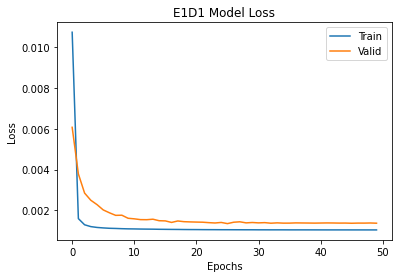

In [97]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

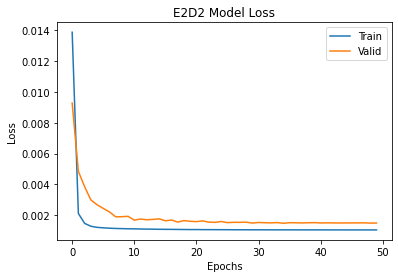

In [98]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [99]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

# pred_e1d1=model_e1d1.predict(X_train)
# pred_e2d2=model_e2d2.predict(X_train)

In [100]:
pred1_e1d1.shape

(4934, 1, 26)

In [101]:
pred1_e1d1 = scaler.inverse_transform(pred1_e1d1.reshape(pred1_e1d1.shape[0], pred1_e1d1.shape[2]))
forecast_e1d1 = pd.DataFrame(pred1_e1d1,columns=list(validation_df.columns))

pred1_e2d2 = scaler.inverse_transform(pred1_e2d2.reshape(pred1_e2d2.shape[0], pred1_e2d2.shape[2]))
forecast_e2d2 = pd.DataFrame(pred1_e2d2,columns=list(validation_df.columns))

In [124]:
forecast_e1d1

,Appliances(t),lights(t),T1(t),RH_1(t),T2(t),RH_2(t),T3(t),RH_3(t),T4(t),RH_4(t),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
0,248.570938,0.931732,22.408905,38.755028,22.384439,35.500011,24.246899,35.680450,22.529625,34.758492,...,23.436953,38.236336,20.798698,39.453690,8.545581,757.054504,63.290886,5.333335,39.700321,1.812991
1,251.875595,0.994288,22.441740,38.390762,22.390669,35.383026,24.450670,35.773811,22.526217,34.734768,...,23.506092,38.185356,20.793907,39.236839,8.643850,757.112427,62.504177,5.171319,39.688427,1.697711
2,283.237213,1.005192,22.458981,38.371132,22.362240,35.305359,24.891268,36.162178,22.517483,34.641544,...,23.555468,38.067322,20.792402,38.917648,8.719584,757.122925,61.725910,5.000193,39.631660,1.588485
3,312.949921,1.101300,22.470545,38.360882,22.289520,35.306137,25.215799,36.677071,22.508789,34.624439,...,23.556919,37.896061,20.789043,38.791031,8.713462,757.093811,61.426201,4.999529,39.587055,1.513632
4,213.553391,1.013716,22.436739,38.035942,22.227535,35.169712,25.427986,36.795528,22.507305,34.586529,...,23.593620,37.881119,20.795271,38.936726,8.612599,757.105103,61.253815,4.996364,39.647018,1.406502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,135.259277,1.309046,25.148573,46.226330,25.741762,42.226460,26.973515,41.112053,24.582808,45.752037,...,24.272610,50.152367,22.756670,46.391705,21.782904,754.215698,56.761562,3.408332,25.881527,13.029304
4930,136.248276,1.249202,25.195230,46.028000,25.657835,41.887974,26.871927,41.202660,24.574100,45.741676,...,24.300827,49.831234,22.767225,46.444847,21.644737,754.209045,57.074966,3.550905,26.535830,12.998488
4931,127.484444,1.262598,25.141035,45.996803,25.527714,41.954060,26.813799,41.253845,24.565964,45.742378,...,24.302237,49.563274,22.772295,46.474590,21.503969,754.226929,57.388973,3.691918,27.185863,12.968596
4932,235.612152,6.937085,25.151186,46.248466,25.402431,42.565258,26.828625,41.699486,24.568848,46.064369,...,24.317621,49.314075,22.746313,46.684937,21.500555,754.142761,57.603638,3.824542,27.657921,12.915200


In [121]:
test_val_df

,Appliances(t),lights(t),T1(t),RH_1(t),T2(t),RH_2(t),T3(t),RH_3(t),T4(t),RH_4(t),...,T8(t),RH_8(t),T9(t),RH_9(t),T_out(t),Press_mm_hg(t),RH_out(t),Windspeed(t),Visibility(t),Tdewpoint(t)
14801,280.0,0.0,22.390000,37.930000,22.390000,35.400000,24.430000,35.723333,22.5,34.790000,...,23.456000,38.378000,20.79,39.296667,8.450000,756.933333,62.833333,5.166667,40.000000,1.716667
14802,320.0,0.0,22.390000,37.863333,22.356667,35.290000,24.860000,36.133333,22.5,34.700000,...,23.500000,38.264286,20.79,38.963333,8.500000,757.000000,62.000000,5.000000,40.000000,1.600000
14803,360.0,0.0,22.390000,37.790000,22.290000,35.290000,25.172500,36.675000,22.5,34.700000,...,23.500000,38.090000,20.79,38.826667,8.500000,757.000000,61.666667,5.000000,40.000000,1.516667
14804,210.0,0.0,22.390000,37.790000,22.230000,35.200000,25.430000,36.900000,22.5,34.700000,...,23.557143,37.998571,20.79,38.966667,8.500000,757.000000,61.333333,5.000000,40.000000,1.433333
14805,90.0,0.0,22.426667,39.100000,22.290000,35.460000,25.633333,36.900000,22.5,34.700000,...,23.600000,37.860000,20.79,39.000000,8.500000,757.000000,61.000000,5.000000,40.000000,1.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,24.700000,50.074000,23.20,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333
19731,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,24.700000,49.790000,23.20,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000
19732,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,24.700000,49.660000,23.20,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667
19733,420.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,24.662500,49.518750,23.20,46.817500,22.333333,755.200000,56.666667,3.833333,26.166667,13.233333


Appliances(t)
RMSE-E1D1 :  60.53582955916473, RMSE-E2D2 :  61.95788958111363
R2-E1D1 :  0.5298104261428733, R2-E2D2 :  0.5074603119430565
MAE-E1D1 :  30.18939133448112, MAE-E2D2 :  34.418534745849186


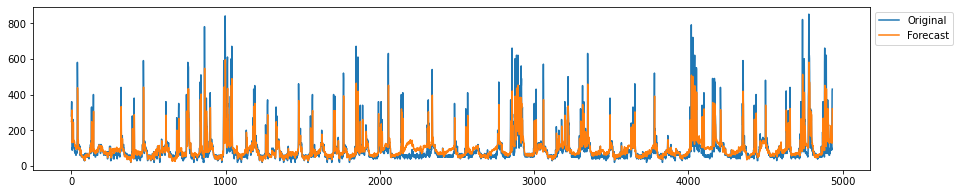


lights(t)
RMSE-E1D1 :  3.9196045470966943, RMSE-E2D2 :  3.923648279308012
R2-E1D1 :  0.5015520923907086, R2-E2D2 :  0.5005230959469957
MAE-E1D1 :  2.1636093083088053, MAE-E2D2 :  2.165918874822747


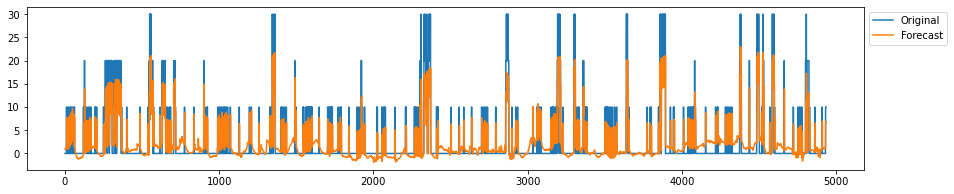


T1(t)
RMSE-E1D1 :  0.23114199398767557, RMSE-E2D2 :  0.23492064349686562
R2-E1D1 :  0.9746670559896753, R2-E2D2 :  0.9738320129672955
MAE-E1D1 :  0.17219077121243448, MAE-E2D2 :  0.1749915673336204


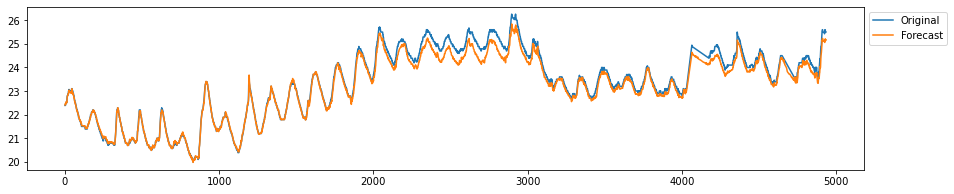


RH_1(t)
RMSE-E1D1 :  0.5452372429119707, RMSE-E2D2 :  0.5496564740493259
R2-E1D1 :  0.9882208325314108, R2-E2D2 :  0.9880291148135207
MAE-E1D1 :  0.3767911981769232, MAE-E2D2 :  0.3882061194848126


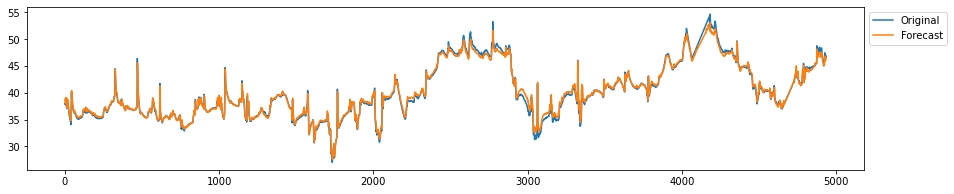


T2(t)
RMSE-E1D1 :  0.21909690628547912, RMSE-E2D2 :  0.20022882631671546
R2-E1D1 :  0.9927224092927939, R2-E2D2 :  0.9939218930168221
MAE-E1D1 :  0.14875950430340934, MAE-E2D2 :  0.134284203573688


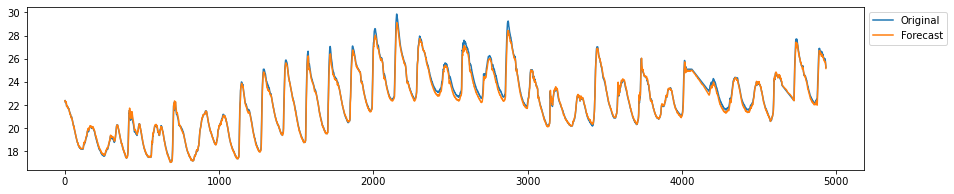


RH_2(t)
RMSE-E1D1 :  0.47504276128844425, RMSE-E2D2 :  0.5223133936765574
R2-E1D1 :  0.9926508124658996, R2-E2D2 :  0.9911154334356753
MAE-E1D1 :  0.32472609051850665, MAE-E2D2 :  0.3490494212837828


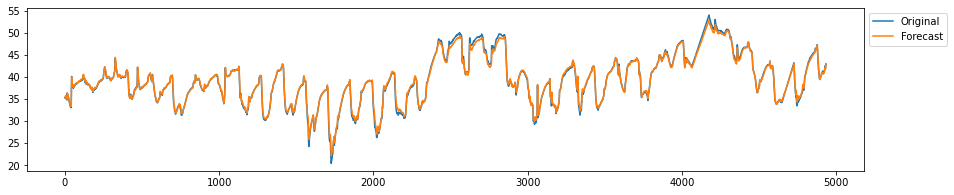


T3(t)
RMSE-E1D1 :  0.14510334464447713, RMSE-E2D2 :  0.16902712754740434
R2-E1D1 :  0.9924983745130121, R2-E2D2 :  0.9898208068633273
MAE-E1D1 :  0.1017564131186023, MAE-E2D2 :  0.12410223181092868


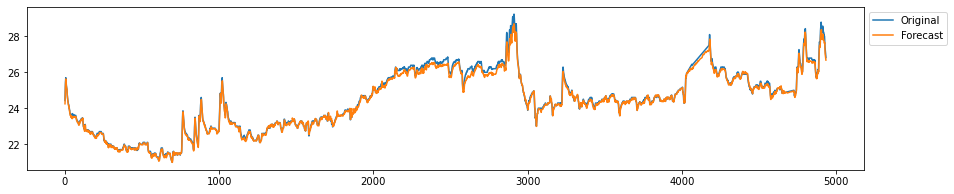


RH_3(t)
RMSE-E1D1 :  0.2762136073954764, RMSE-E2D2 :  0.30348828527481436
R2-E1D1 :  0.9934400405419389, R2-E2D2 :  0.9920805525870126
MAE-E1D1 :  0.17983226054632157, MAE-E2D2 :  0.20116275508167158


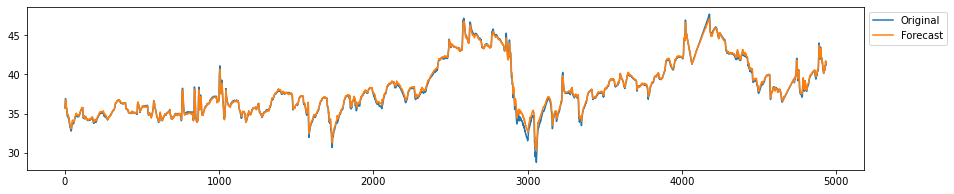


T4(t)
RMSE-E1D1 :  0.1934037535232561, RMSE-E2D2 :  0.1894317633157819
R2-E1D1 :  0.9875022082565601, R2-E2D2 :  0.9880102786374843
MAE-E1D1 :  0.13340172805358474, MAE-E2D2 :  0.12919825804327295


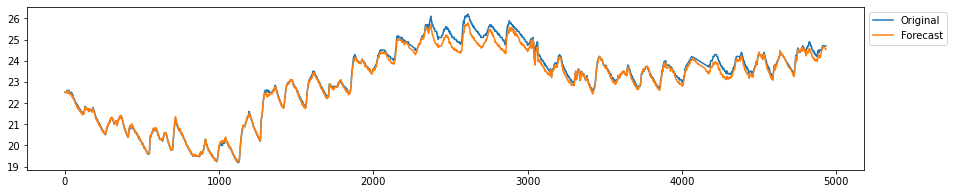


RH_4(t)
RMSE-E1D1 :  0.29856047577580713, RMSE-E2D2 :  0.2947826796447724
R2-E1D1 :  0.9957674543769277, R2-E2D2 :  0.9958738886440808
MAE-E1D1 :  0.2110737749424123, MAE-E2D2 :  0.19968723964089047


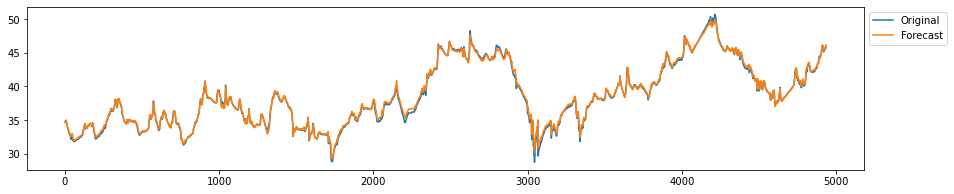


T5(t)
RMSE-E1D1 :  0.2552053557083709, RMSE-E2D2 :  0.2580362593559457
R2-E1D1 :  0.9778856087098801, R2-E2D2 :  0.9773922732051097
MAE-E1D1 :  0.16470504027945357, MAE-E2D2 :  0.17339538680187147


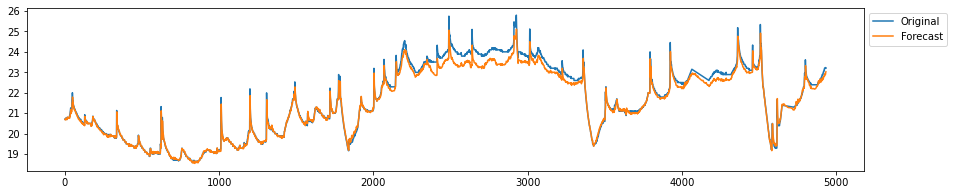


RH_5(t)
RMSE-E1D1 :  2.3834530732383588, RMSE-E2D2 :  2.3584485610969423
R2-E1D1 :  0.92713156025452, R2-E2D2 :  0.9286524480868732
MAE-E1D1 :  1.0707391910972919, MAE-E2D2 :  0.9659198037705524


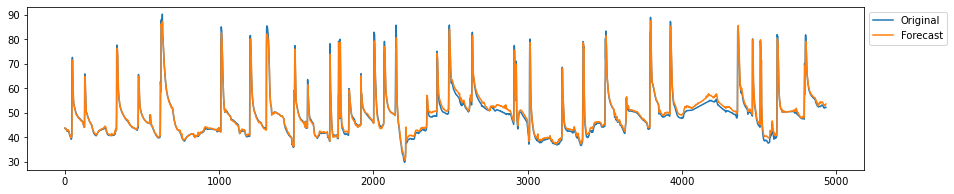


T6(t)
RMSE-E1D1 :  0.5651743578804389, RMSE-E2D2 :  0.6214480712852369
R2-E1D1 :  0.9928854627973358, R2-E2D2 :  0.9913981583280392
MAE-E1D1 :  0.4188594170829072, MAE-E2D2 :  0.43989391976187425


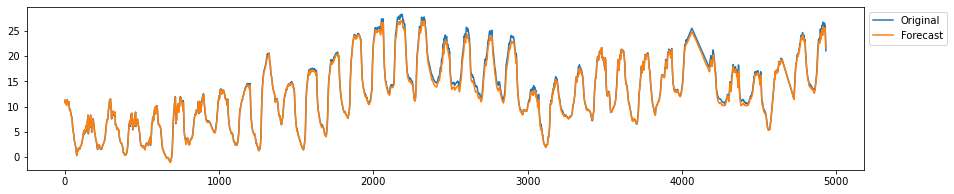


RH_6(t)
RMSE-E1D1 :  2.0346274181072856, RMSE-E2D2 :  2.2730442199735617
R2-E1D1 :  0.990312833698147, R2-E2D2 :  0.987909542372081
MAE-E1D1 :  1.4430118757162278, MAE-E2D2 :  1.653533177203239


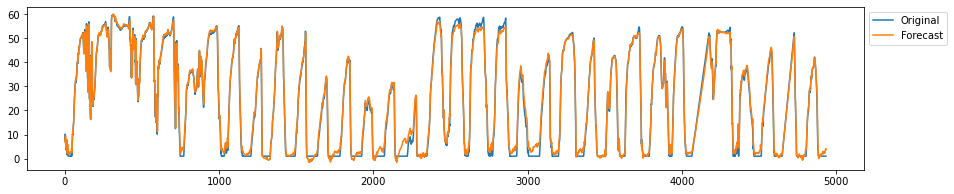


T7(t)
RMSE-E1D1 :  0.17856032918724252, RMSE-E2D2 :  0.2363401826538411
R2-E1D1 :  0.9901241333469208, R2-E2D2 :  0.9826986339318
MAE-E1D1 :  0.1220981959232295, MAE-E2D2 :  0.17505080226882008


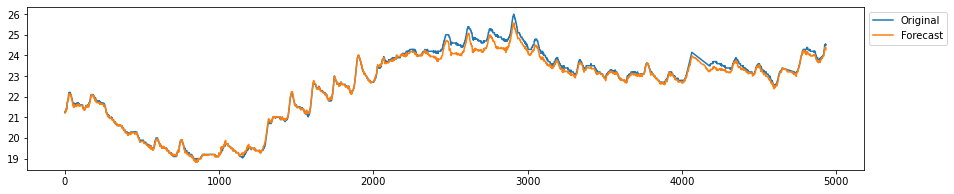


RH_7(t)
RMSE-E1D1 :  0.3294397949726343, RMSE-E2D2 :  0.35033821589822217
R2-E1D1 :  0.9962072987645398, R2-E2D2 :  0.9957108469532421
MAE-E1D1 :  0.2503236818410596, MAE-E2D2 :  0.25346055330524825


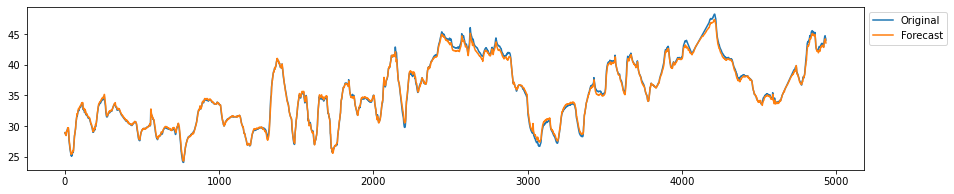


T8(t)
RMSE-E1D1 :  0.2537919059313346, RMSE-E2D2 :  0.2799566154779869
R2-E1D1 :  0.9655290440760811, R2-E2D2 :  0.9580550905050808
MAE-E1D1 :  0.1837027653262008, MAE-E2D2 :  0.2186237442308352


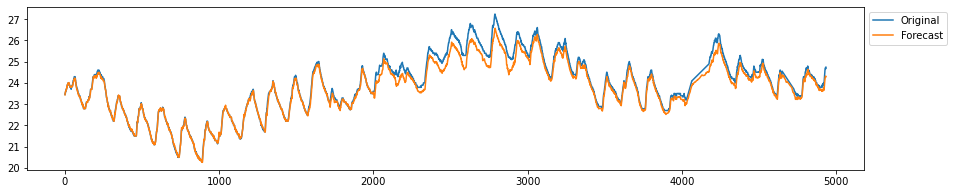


RH_8(t)
RMSE-E1D1 :  0.5013671854637445, RMSE-E2D2 :  0.38636862030032193
R2-E1D1 :  0.9903179981055197, R2-E2D2 :  0.9942501429769324
MAE-E1D1 :  0.35528154510698323, MAE-E2D2 :  0.2745699718596549


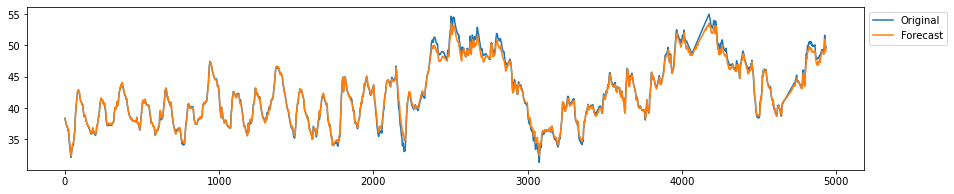


T9(t)
RMSE-E1D1 :  0.24230872014043706, RMSE-E2D2 :  0.2749442164448065
R2-E1D1 :  0.979594050312291, R2-E2D2 :  0.9737271067469079
MAE-E1D1 :  0.17984112683551742, MAE-E2D2 :  0.2064717369256068


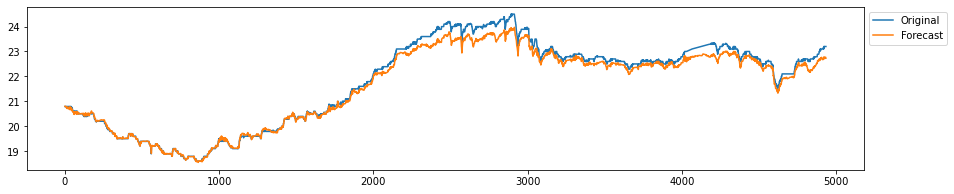


RH_9(t)
RMSE-E1D1 :  0.2561913683564145, RMSE-E2D2 :  0.2821140847232898
R2-E1D1 :  0.9970100729374376, R2-E2D2 :  0.9963743895020148
MAE-E1D1 :  0.18365475386691535, MAE-E2D2 :  0.20363583988695994


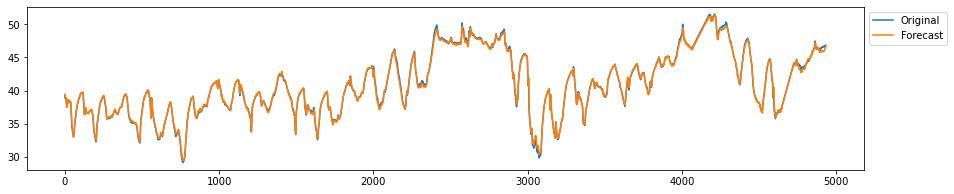


T_out(t)
RMSE-E1D1 :  0.44050555129628655, RMSE-E2D2 :  0.5742997497515018
R2-E1D1 :  0.9941173772217543, R2-E2D2 :  0.9900012552280113
MAE-E1D1 :  0.30742668126073763, MAE-E2D2 :  0.3818748600869553


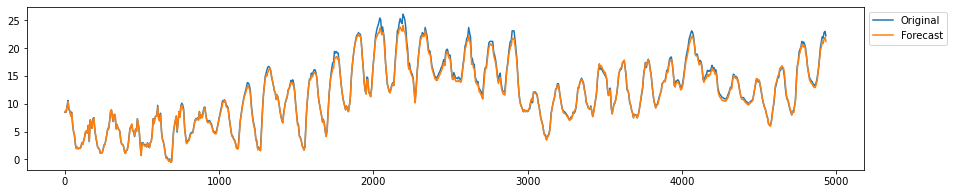


Press_mm_hg(t)
RMSE-E1D1 :  0.48186008292776994, RMSE-E2D2 :  0.5686033473341057
R2-E1D1 :  0.9917381521745988, R2-E2D2 :  0.9884958611860868
MAE-E1D1 :  0.3652865455853063, MAE-E2D2 :  0.3913458836656769


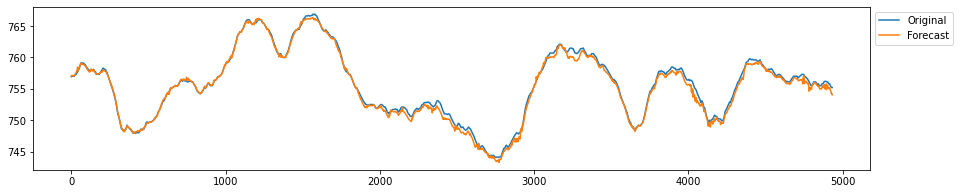


RH_out(t)
RMSE-E1D1 :  1.2347026202783538, RMSE-E2D2 :  1.3378271518471763
R2-E1D1 :  0.9954331365593748, R2-E2D2 :  0.9946384137383851
MAE-E1D1 :  0.9520437787987223, MAE-E2D2 :  1.030847957143589


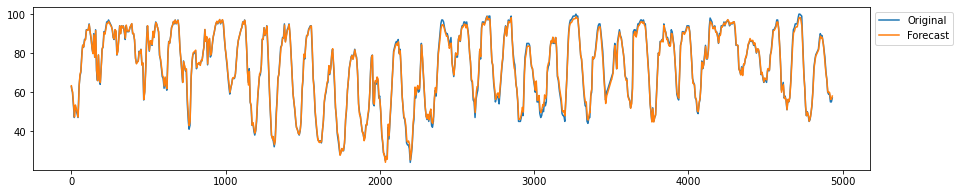


Windspeed(t)
RMSE-E1D1 :  0.24548829697573024, RMSE-E2D2 :  0.24628296855891132
R2-E1D1 :  0.9797794841211095, R2-E2D2 :  0.9796483603359378
MAE-E1D1 :  0.19193352041913278, MAE-E2D2 :  0.18471408054076222


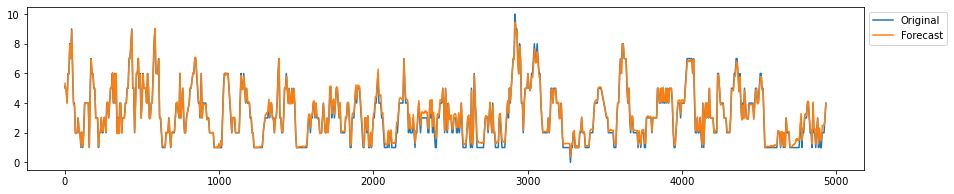


Visibility(t)
RMSE-E1D1 :  1.8947847225069951, RMSE-E2D2 :  1.918732353134988
R2-E1D1 :  0.9517413040782192, R2-E2D2 :  0.9505137402598287
MAE-E1D1 :  1.2061670973876175, MAE-E2D2 :  1.2256531964410176


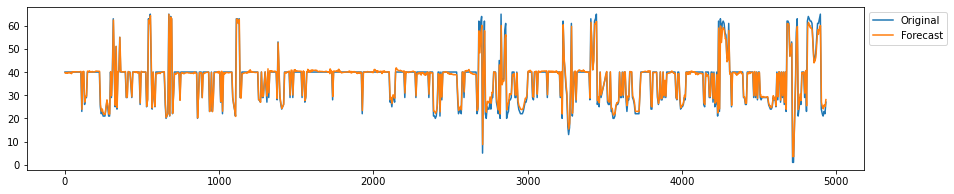


Tdewpoint(t)
RMSE-E1D1 :  0.3045818638471017, RMSE-E2D2 :  0.32290179985106615
R2-E1D1 :  0.995451137001865, R2-E2D2 :  0.994887471892561
MAE-E1D1 :  0.23062835923901157, MAE-E2D2 :  0.24527158427975587


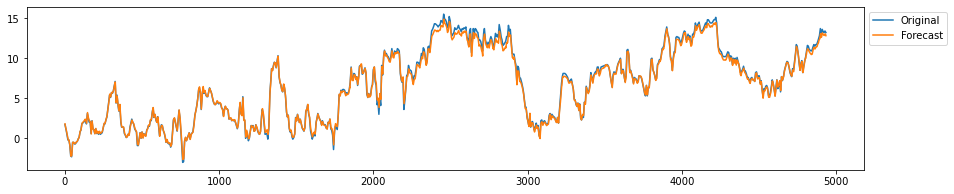

In [122]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
 
# original = original[:len(original)-1]
# forecast = forecast[1:]  

validation_df = test_val_df
    
for index,i in enumerate(validation_df.columns):
    print(i)
    
    original = validation_df[i].values
    forecast1 = forecast_e1d1[i].values
    forecast2 = forecast_e2d2[i].values
#     original = original[:len(original)-1]
#     forecast1 = forecast1[1:]
#     forecast2 = forecast2[1:]
    
    print("RMSE-E1D1 : ",mean_squared_error(original,forecast1,squared=False),end=", ")
    print("RMSE-E2D2 : ",mean_squared_error(original,forecast2,squared=False))
    print("R2-E1D1 : ",r2_score(original,forecast1),end=", ")
    print("R2-E2D2 : ",r2_score(original,forecast2))
    print("MAE-E1D1 : ",mean_absolute_error(original,forecast1),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(original,forecast2))
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
    ax.plot(original, label='Original')
    ax.plot(forecast1, label='Forecast')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
    plt.show()
    
    print()

In [30]:
# for index,i in enumerate(train_df.columns):
#     scaler = scalers['scaler_'+i]
#     pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
#     pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    
#     pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
#     pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
#     y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
#     y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [31]:
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
 
# for index,i in enumerate(train_df.columns):
#   print(i)
#   for j in range(0,1):
#     #print("Day ",j,":")
#     print("RMSE-E1D1 : ",mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index],squared=False),end=", ")
#     print("RMSE-E2D2 : ",mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index],squared=False))
#     print("R2-E1D1 : ",r2_score(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
#     print("R2-E2D2 : ",r2_score(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
#     print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
#     print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
#   print()
#   print()